In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten,Dropout, Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error as mse
from functions_learning import *
from feed_data import data_extract
from tensorflow import keras
from keras import layers

In [26]:
def plot_predictions1(model, X, y, start=0, end=100):
    prediction = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':prediction, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.title("Predictions")
    plt.show()
    mse_v = mse(y, prediction)
    return mse_v


def plot_train_history(history):
    plt.plot(history.history['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss History')
    plt.show()
    
def fit_model(model, cp, epochs, xt, yt, xv, yv):
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[RootMeanSquaredError()])
    history = model.fit(xt, yt, validation_data=(xv, yv), epochs=epochs, callbacks=[cp], verbose=0)
    return model, history

def save_history(history, fname):
    training_loss = history.history['loss']
    validation_loss = history.history.get('val_loss', None)  # Handle optional key
    training_acc = history.history.get('accuracy', None)  # Handle optional key
    validation_acc = history.history.get('val_accuracy', None)  # Handle optional key

    # Create a dictionary
    history_data = {
        'training_loss': training_loss,
        'validation_loss': validation_loss,
        'training_accuracy': training_acc,
        'validation_accuracy': validation_acc}
    history_df = pd.DataFrame(history_data)
    history_df.to_csv(f"epochs{epochs}/history_{fname}.csv")
    

## Data Format

In [27]:
data = pd.read_csv("data/LocationA.csv")
data = data.drop(columns=["Unnamed: 0", "Date"])
data.head()

,TempA,pHA,ECA,DOA,BODA,TNA
0,21.50,7.73,1748,2.55,27.96,1.28
1,21.21,7.82,1765,2.60,27.90,1.08
2,21.21,7.73,1769,2.59,27.88,1.17
3,21.26,7.82,1776,2.63,27.66,1.15
4,21.09,7.76,1822,2.60,27.71,1.22


In [28]:
target_column = "BODA"
features = data.drop(target_column, axis=1)
target = data[target_column]

In [29]:
X = []
y = []
for i in range(5, len(features)):
    X.append(features.iloc[i-5:i, :].values.ravel())  # Flatten features
    y.append(target.iloc[i])

X = np.array(X)
y = np.array(y)

In [30]:
X[0], y[0]

(array([2.150e+01, 7.730e+00, 1.748e+03, 2.550e+00, 1.280e+00, 2.121e+01,
        7.820e+00, 1.765e+03, 2.600e+00, 1.080e+00, 2.121e+01, 7.730e+00,
        1.769e+03, 2.590e+00, 1.170e+00, 2.126e+01, 7.820e+00, 1.776e+03,
        2.630e+00, 1.150e+00, 2.109e+01, 7.760e+00, 1.822e+03, 2.600e+00,
        1.220e+00]),
 27.63)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=1)

In [32]:
x_train.shape, y_train.shape

((176, 25), (176,))

In [33]:
xt = x_train.copy()
xt = xt.reshape(176,25,1)
xt.shape

(176, 25, 1)

In [34]:
x_test = x_test.reshape(108, 25, 1)
x_test.shape

(108, 25, 1)

x_test = x_test.reshape(72, 25, 1)
x_test.shape

In [35]:
window_size = 5

def moving_average(data, window_size):
    cumsum = np.cumsum(data, axis=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

moving_avg_data = np.apply_along_axis(lambda x: moving_average(x, window_size), axis=0, arr=xt)
target = y_train[window_size - 1:].flatten()

In [36]:
moving_avg_data.shape, target.shape

((172, 25, 1), (172,))

In [37]:
epochs = 100
x_train = xt.copy()
input_shape = (25,1)

# General Model

### CNN

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


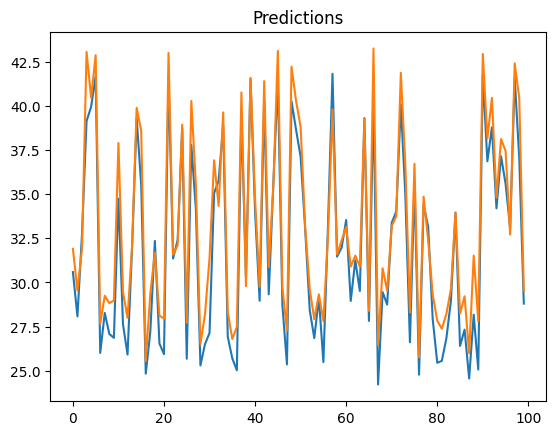

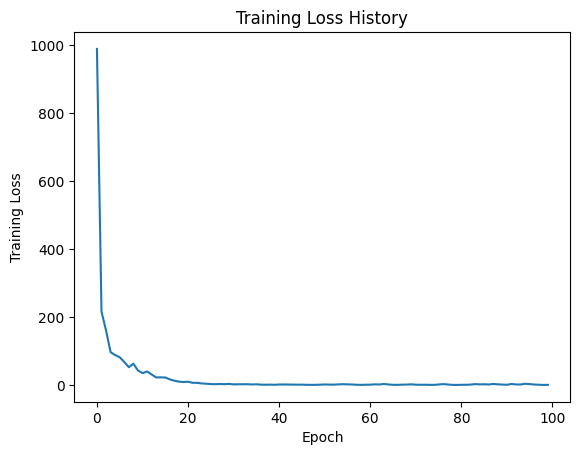

In [38]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(Conv1D(64, kernel_size=2))
model.add(Flatten())
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

'''
model = keras.Sequential([
  keras.layers.Conv1D(32, kernel_size=3, activation="relu", input_shape=input_shape),
  keras.layers.MaxPooling1D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation="relu"),
  keras.layers.Dense(1) 
])
'''

mname = f"epochs{epochs}/cnn.keras"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)
cnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "cnn")

In [39]:
cnn_mse

2.4500060758004403

### GRU

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


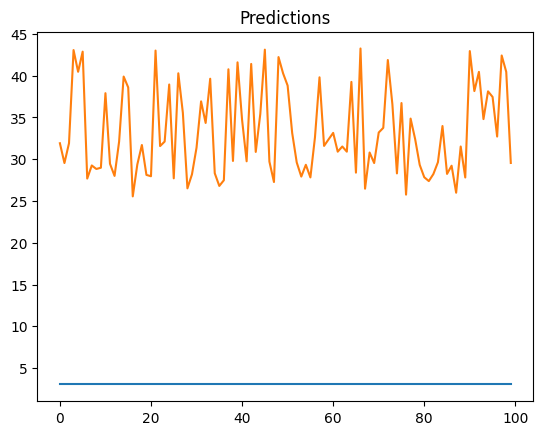

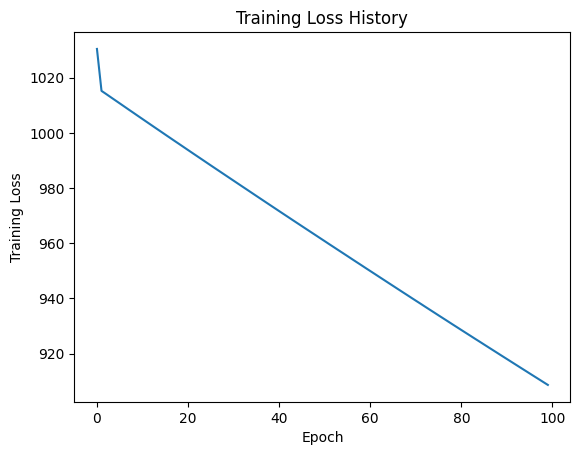

In [40]:
model = keras.Sequential([
    layers.GRU(units=512, return_sequences=True, input_shape=input_shape),
    layers.Dense(units=32),
    layers.GRU(units=2, activation="tanh"),
    layers.Dense(1) 
  ])

mname = f"epochs{epochs}/gru.keras"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)
gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "gru")

In [41]:
gru_mse

934.7881343362745

### LSTM

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x158f23ec0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


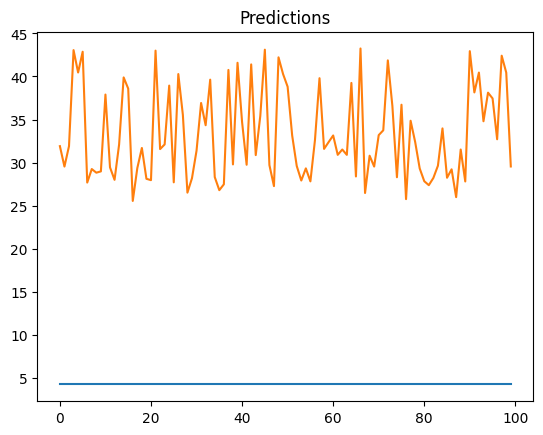

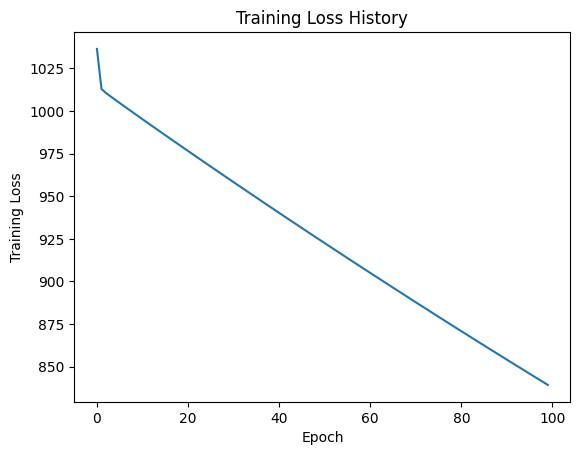

In [42]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(LSTM(512))
model.add(Dense(8, "sigmoid"))
model.add(Dense(1, 'linear'))

mname = f"epochs{epochs}/lstm.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)

lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "lstm")

In [43]:
lstm_mse

863.9779410206648

### RNN

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


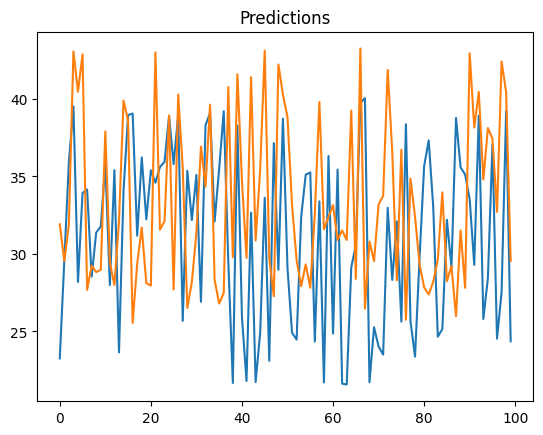

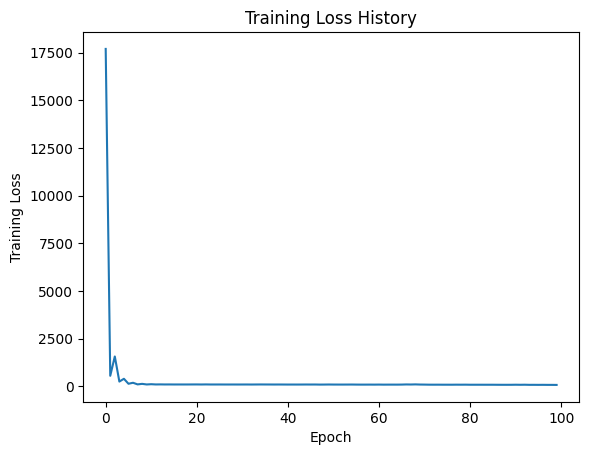

In [44]:
model = keras.Sequential([
    layers.SimpleRNN(units=128, input_shape=input_shape),
    layers.Dense(8),
    layers.Dense(1)
])


model = Sequential([
    SimpleRNN(50, input_shape=input_shape, activation='relu'),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/rnn.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)

rnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "rnn")

In [45]:
rnn_mse

58.16728353603529

# Moving Average

In [46]:
window_size = 5

def moving_average(data, window_size):
    cumsum = np.cumsum(data, axis=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

moving_avg_data = np.apply_along_axis(lambda x: moving_average(x, window_size), axis=0, arr=x_train)
target = y_train[window_size - 1:].flatten()

#### CNN

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


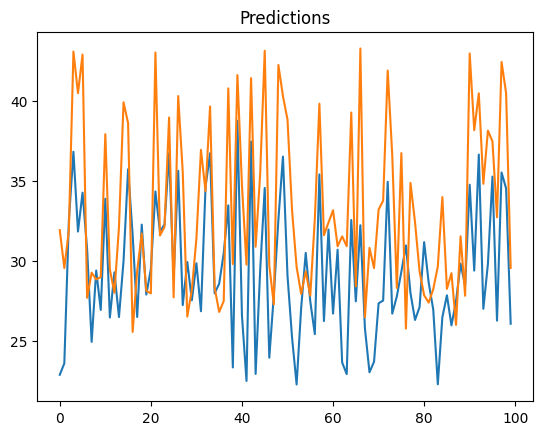

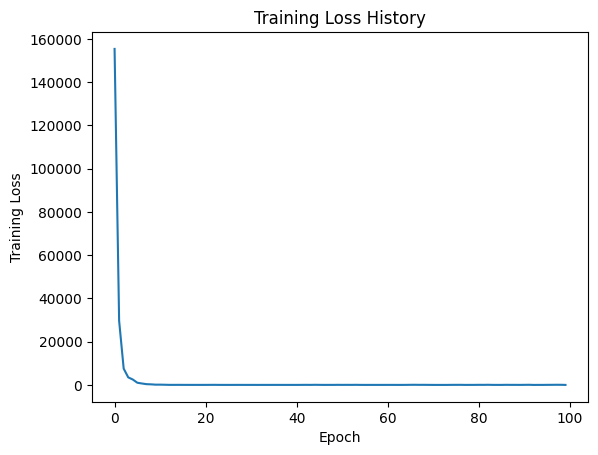

In [47]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(Conv1D(64, kernel_size=2))
model.add(Flatten())
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model = keras.Sequential([
  keras.layers.Conv1D(256, kernel_size=3, activation="relu", input_shape=input_shape),
  keras.layers.MaxPooling1D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(128), 
  keras.layers.Dense(64, activation="relu"),
  keras.layers.Dense(1) 
])



mname = f"epochs{epochs}/mavg_cnn.keras"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, moving_avg_data, target,x_val, y_val)

mvg_cnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_cnn")

In [48]:
mvg_cnn_mse

30.898749004865273

mvg_cnn_mse

#### GRU

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


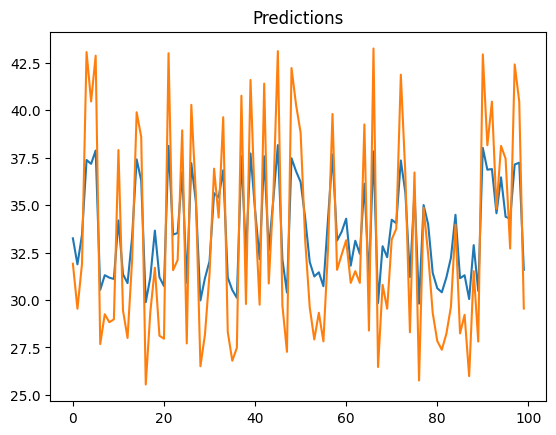

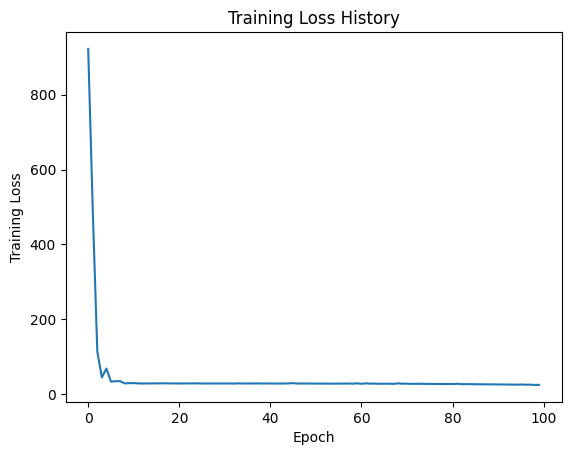

In [49]:
model = keras.Sequential([
    layers.GRU(units=128, input_shape=input_shape),
    layers.Dense(64),
    layers.Dense(8),
    layers.Dense(units=1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_gru.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs,  moving_avg_data, target, x_val, y_val)

mvg_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_gru")

#### LSTM

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


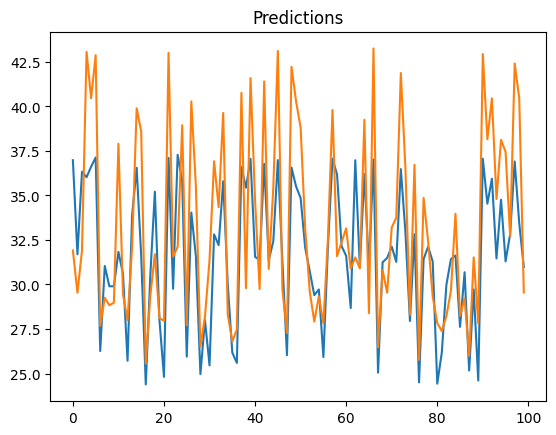

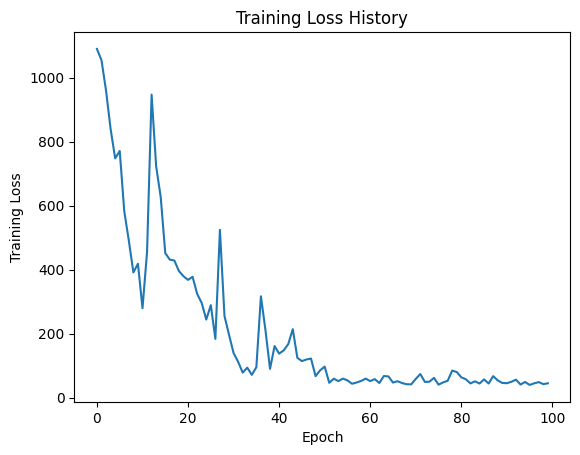

In [50]:
model = keras.Sequential([
  keras.layers.LSTM(units=128, return_sequences=True, input_shape=(input_shape)),  # First LSTM layer
  keras.layers.LSTM(units=64),  # Second LSTM layer
  layers.Dense(units=8),
  keras.layers.Dense(units=1)  # Output layer with 1 unit for single-value prediction
])

'''
model = Sequential()
model.add(InputLayer(input_shape))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
'''

model = keras.Sequential([
    keras.layers.LSTM(50, return_sequences=True, input_shape=input_shape),
    keras.layers.LSTM(50),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)
  ])


mname = f"epochs{epochs}/mavg_lstm.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mvg_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_lstm")

In [51]:
mvg_lstm_mse

11.33689141230539

#### RNN

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


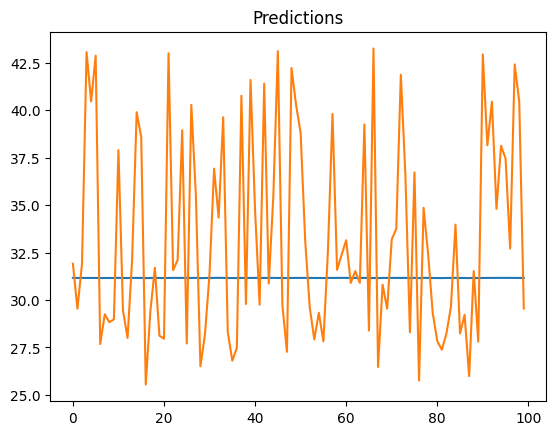

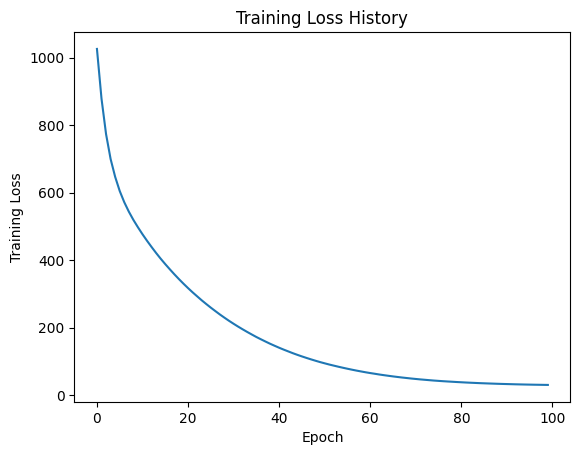

In [52]:
model = keras.Sequential([
    layers.SimpleRNN(units=64, activation="tanh", input_shape=input_shape),
    layers.Dense(units=1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_rnn.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mvg_rnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_rnn")

In [53]:
mvg_rnn_mse

30.724507024551265

# AutoEncoder

### CNN

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


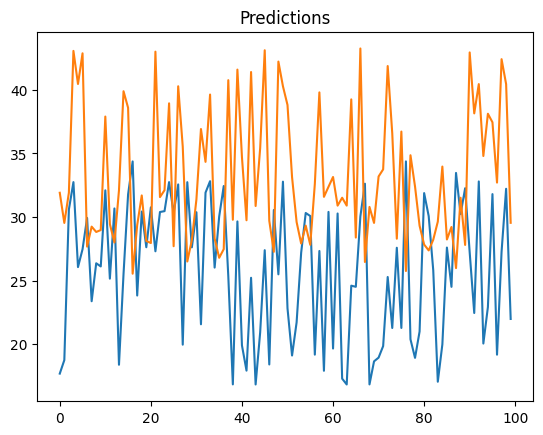

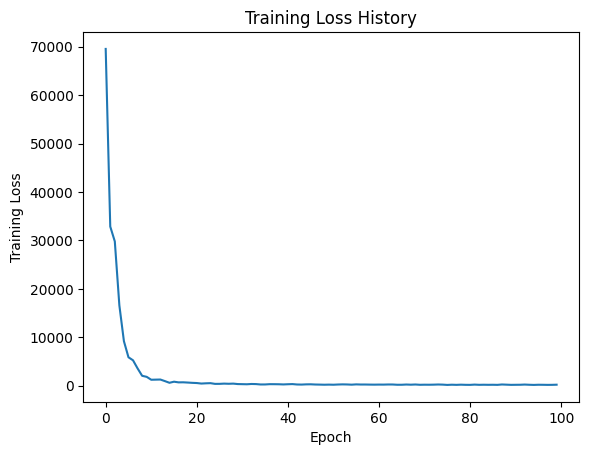

In [54]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(Conv1D(64, kernel_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(32, kernel_size=1))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model = keras.Sequential([
  keras.layers.Conv1D(32, kernel_size=3, activation="relu", input_shape=input_shape),
  keras.layers.Dropout(0.2), 
  keras.layers.MaxPooling1D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation="relu"),
  keras.layers.Dropout(0.4),  
  keras.layers.Dense(1)  
])

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/autoencoder_cnn.keras"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)

auto_cnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "auto_cnn")

In [55]:
auto_cnn_mse

108.8473795965949

### GRU

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


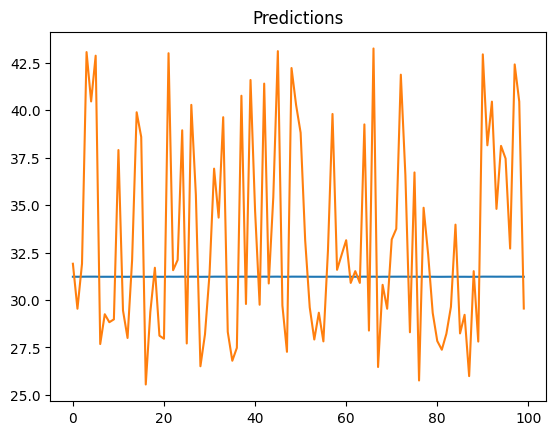

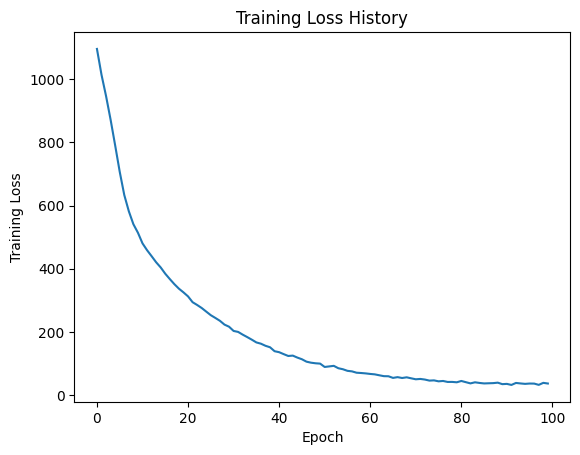

In [56]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))


model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/auto_gru.keras"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)

auto_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "auto_gru")

In [57]:
auto_gru_mse

30.460385708005635

### LSTM

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


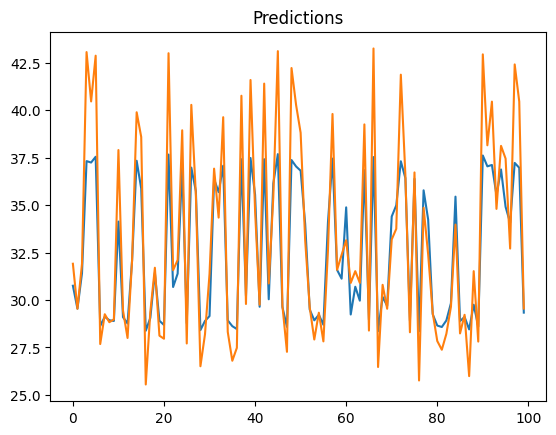

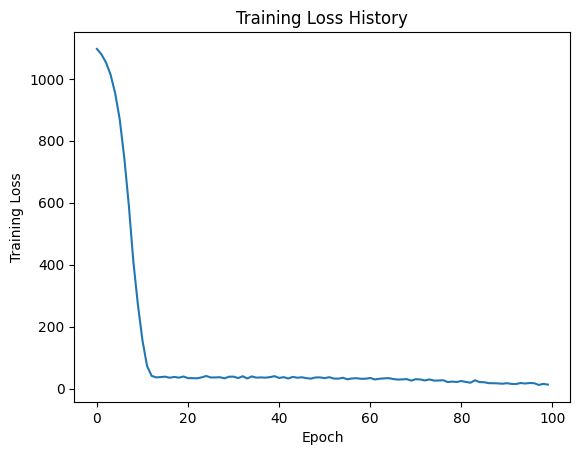

In [58]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(LSTM(64))
model.add(Dropout(0.3))
#model.add(RepeatVector(3))
#model.add(LSTM(64, return_sequences=True))
#model.add(Dropout(0.4))
model.add(Dense(32))
model.add(Dense(8, 'relu'))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/auto_lstm.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)


auto_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "auto_lstm")

In [59]:
auto_lstm_mse

4.723078268517411

### RNN

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


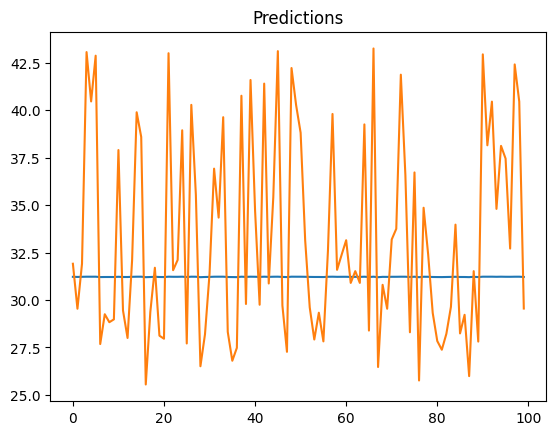

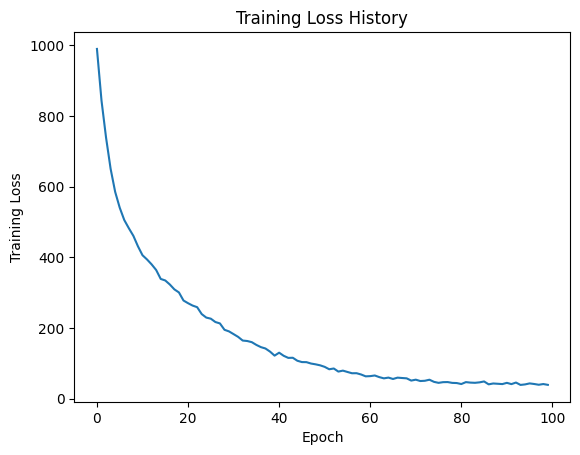

In [60]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(SimpleRNN(64))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/auto_rnn.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)


auto_rnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "auto_rnn")

In [61]:
auto_rnn_mse

30.444174454496565

# Moving Average with Encoder

### CNN

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


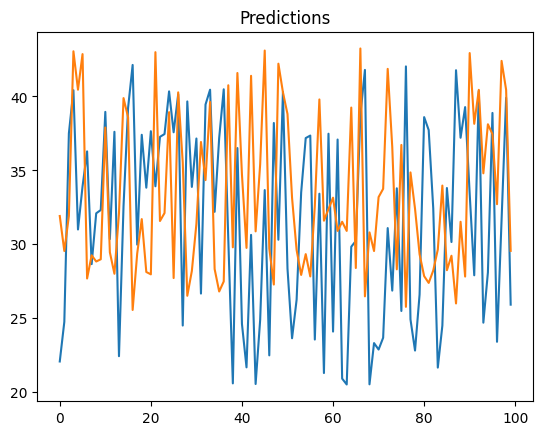

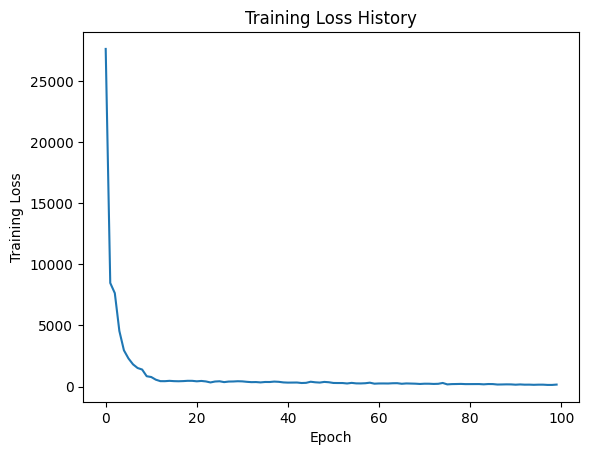

In [62]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(Conv1D(64, kernel_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16, "relu"))
model.add(Dense(1, 'linear'))


model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_auto_cnn.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_auto_cnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_auto_cnn")

In [63]:
mavg_auto_cnn_mse

72.93809576432288

### RNN

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


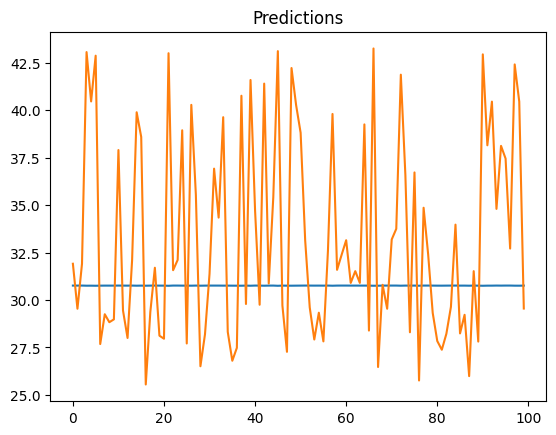

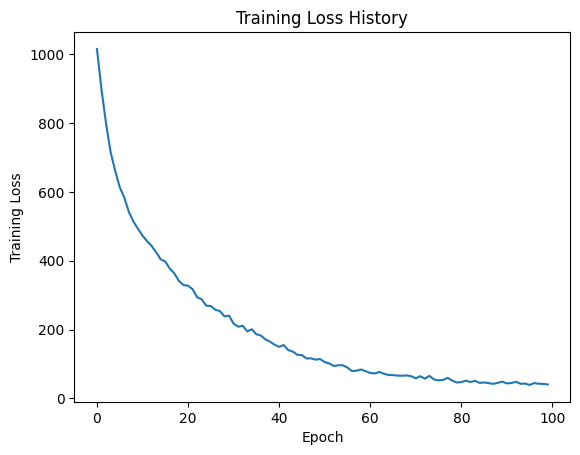

In [64]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(SimpleRNN(64))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_auto_rnn.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs,moving_avg_data,target, x_val, y_val)

mavg_auto_rnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_auto_rnn")

In [65]:
mavg_auto_rnn_mse

32.544287669149035

### GRU

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


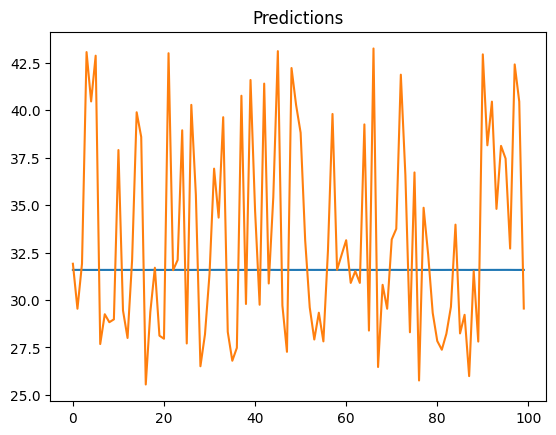

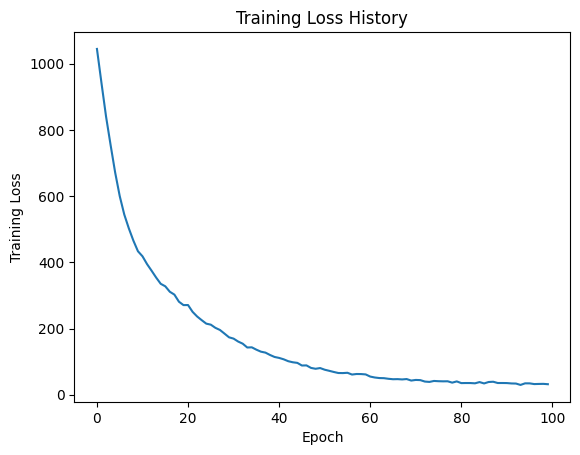

In [66]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_auto_gru.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_auto_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_auto_gru")

In [67]:
mavg_auto_gru_mse

29.215396735063297

### LSTM

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


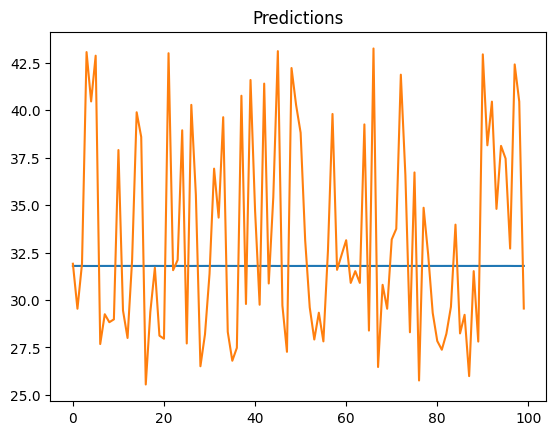

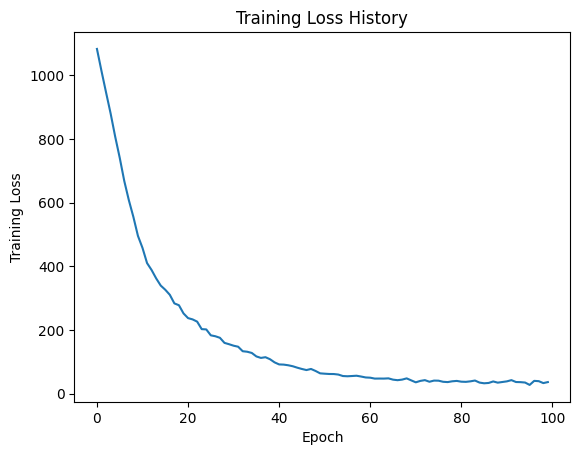

In [68]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(LSTM(64))
model.add(Dropout(0.3))
#model.add(RepeatVector(3))
#model.add(LSTM(64, return_sequences=True))
#model.add(Dropout(0.4))
#model.add(Dense(8, 'relu'))
#model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_auto_lstm.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs,moving_avg_data, target, x_val, y_val)

mavg_auto_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_auto_lstm")

In [69]:
mavg_auto_lstm_mse

28.6012678970296

# Hybrid

## General

### CNN LSTM

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


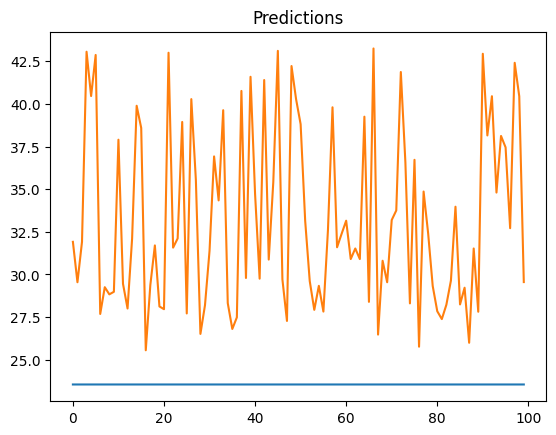

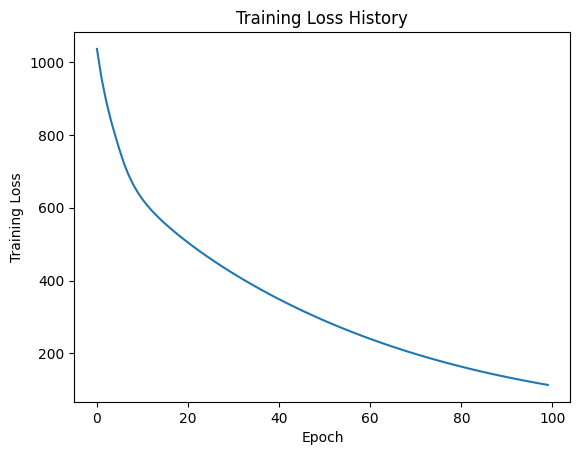

In [70]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(RepeatVector(n=input_shape[0]))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_cnn_lstm.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_cnn_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_cnn_lstm")

In [71]:
hybrid_cnn_lstm_mse

119.4505436872949

### RNN LSTM

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


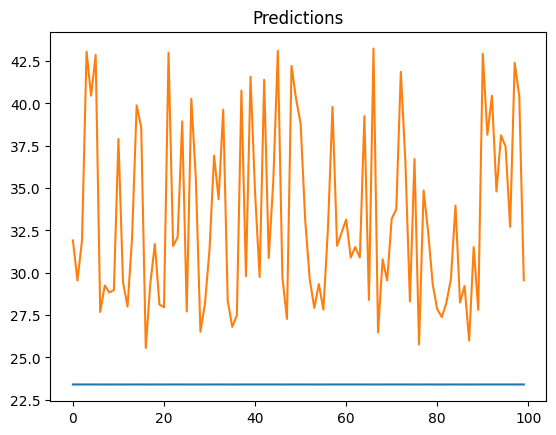

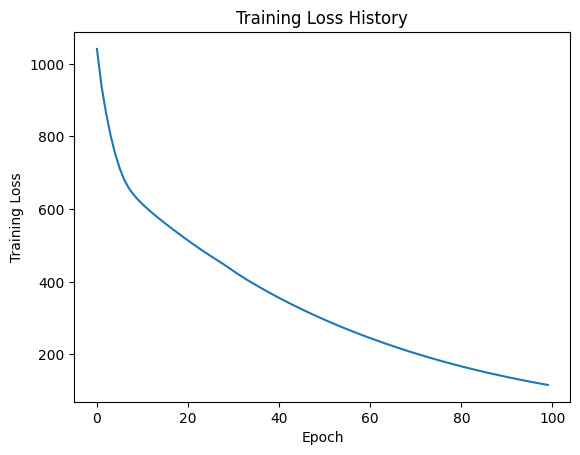

In [72]:
model = Sequential()
model.add(SimpleRNN(64,return_sequences=True, input_shape=input_shape))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_rnn_lstm.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_rnn_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_rnn_lstm")

In [73]:
hybrid_rnn_lstm_mse

122.28160090379616

### RNN GRU

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


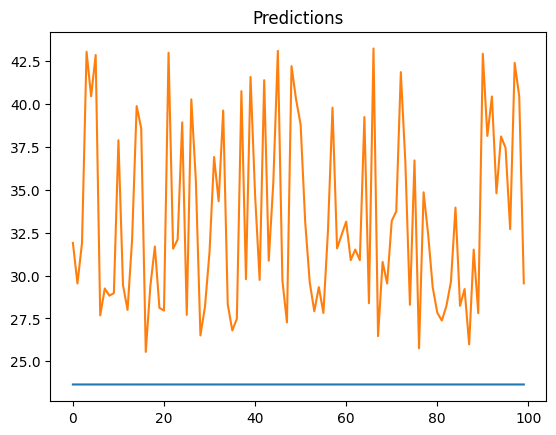

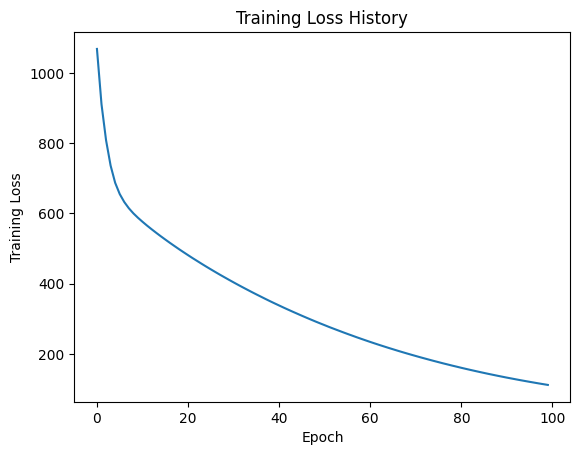

In [74]:
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=input_shape))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_rnn_gru.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_rnn_gru")

In [75]:
hybrid_rnn_gru_mse

117.42318426282097

### CNN GRU

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


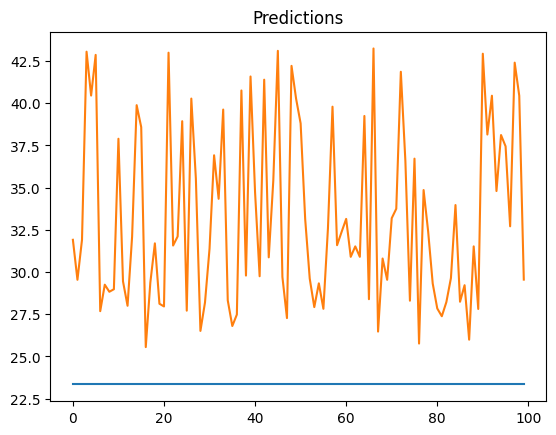

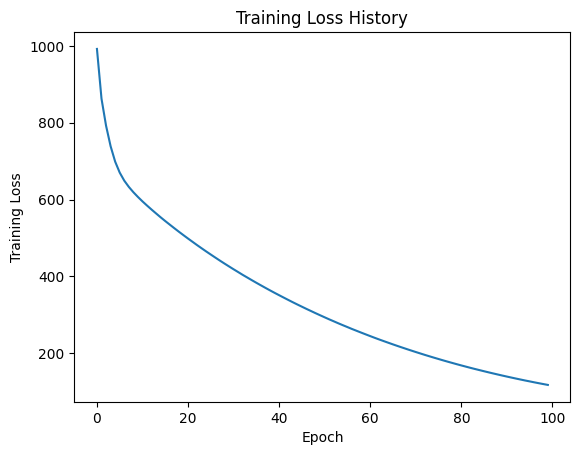

In [76]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Flatten())

model.add(RepeatVector(n=15))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_cnn_gru.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_cnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_cnn_gru")

In [77]:
hybrid_cnn_gru_mse

123.53021551886239

### CNN RNN GRU

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


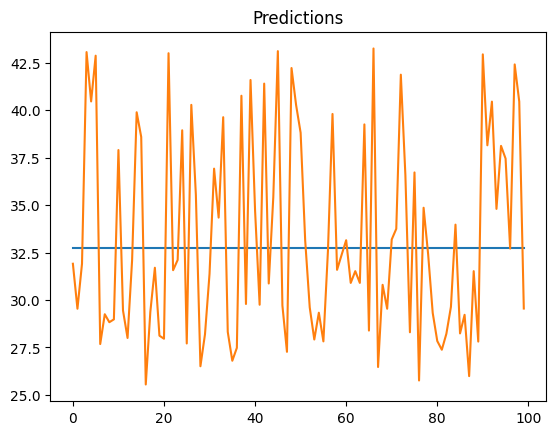

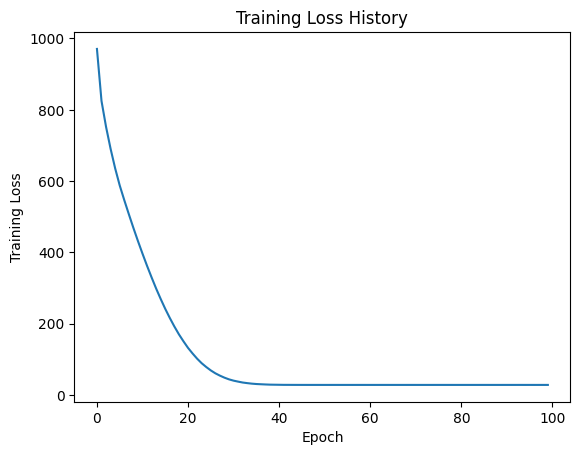

In [78]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(RepeatVector(n=15))
model.add(SimpleRNN(64, return_sequences=True))
model.add(GRU(32))
model.add(Dense(8))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_cnn_rnn_gru.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_cnn_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_cnn_rnn_gru")

In [79]:
hybrid_cnn_rnn_gru_mse

26.882093929397396

### LSTM RNN GRU

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


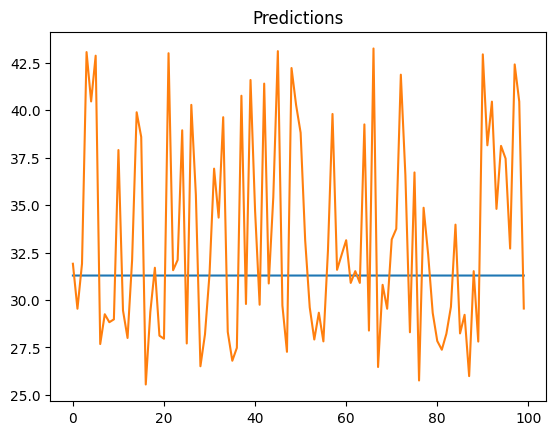

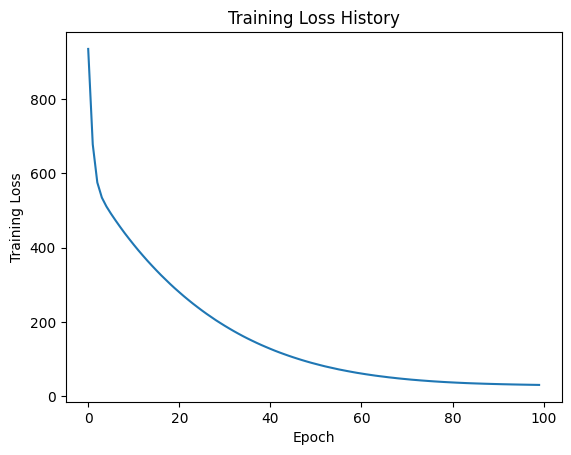

In [80]:
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=input_shape))
model.add(LSTM(128, return_sequences=True))
model.add(GRU(64))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_lstm_rnn_gru.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history =fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_lstm_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_lstm_rnn_gru")

In [81]:
hybrid_lstm_rnn_gru_mse

30.246456309516926

## Moving Average

### CNN LSTM

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


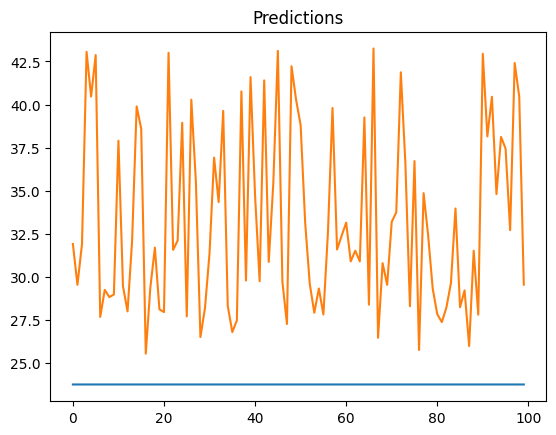

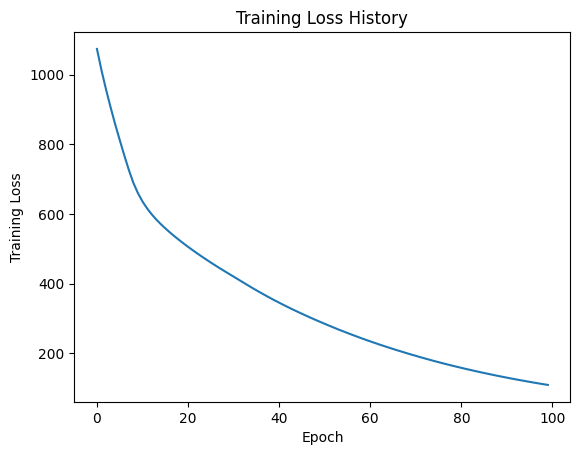

In [82]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(RepeatVector(n=input_shape[0]))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_hybrid_cnn_lstm.keras"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_cnn_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_cnn_lstm")

In [83]:
mavg_hybrid_cnn_lstm_mse

115.31715340893605

### RNN LSTM

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


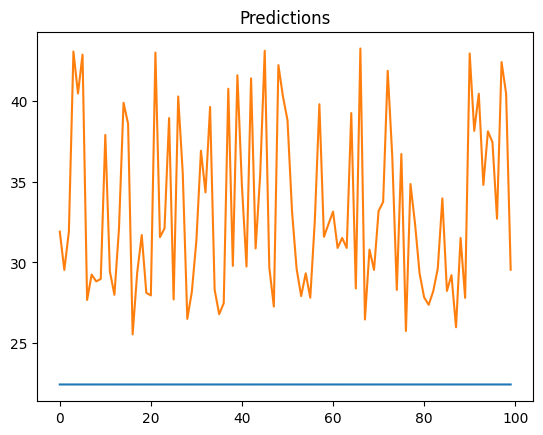

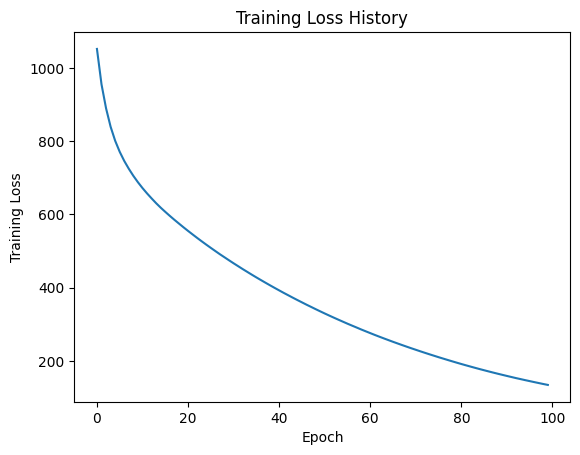

In [84]:
model = Sequential()
model.add(SimpleRNN(64,return_sequences=True, input_shape=input_shape))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_rnn_lstm.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_rnn_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_rnn_lstm")

In [85]:
mavg_hybrid_rnn_lstm_mse

141.76603892271962

### RNN GRU

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


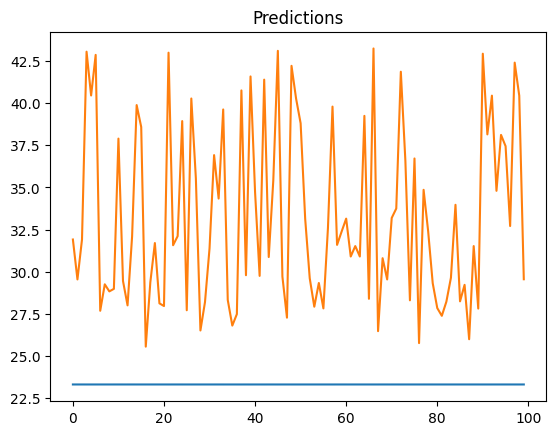

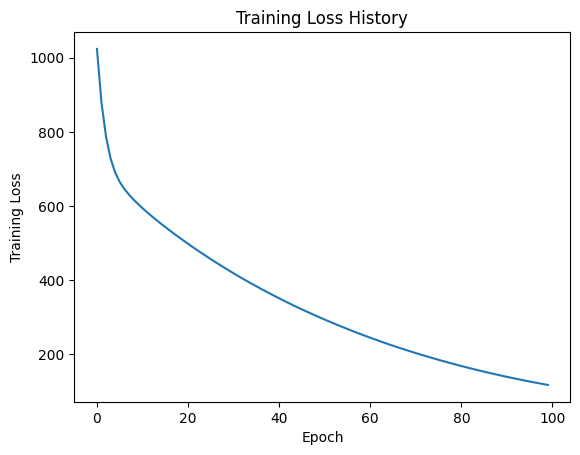

In [86]:
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=input_shape))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_rnn_gru.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_rnn_gru")

In [87]:
mavg_hybrid_rnn_gru_mse

124.12940759672718

### CNN GRU

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


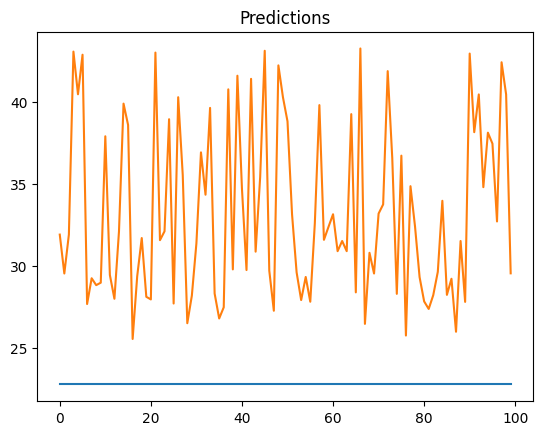

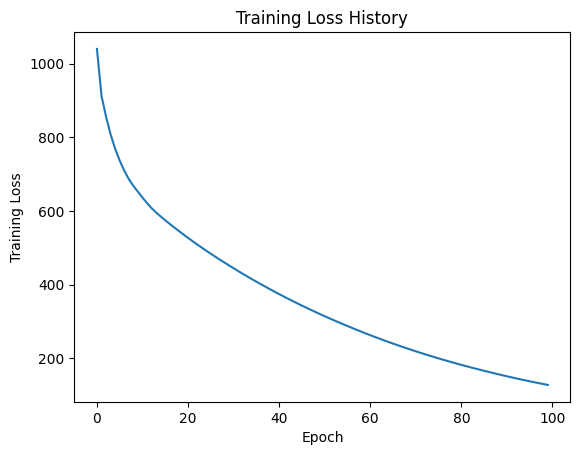

In [88]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(RepeatVector(n=15))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_cnn_gru.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_cnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_cnn_gru")

In [89]:
mavg_hybrid_cnn_gru_mse

134.80185713857847

### CNN RNN GRU

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


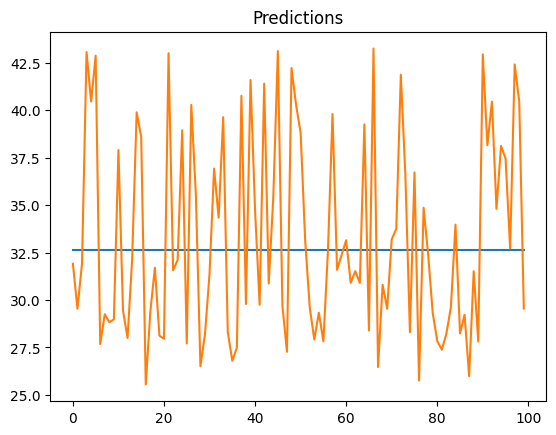

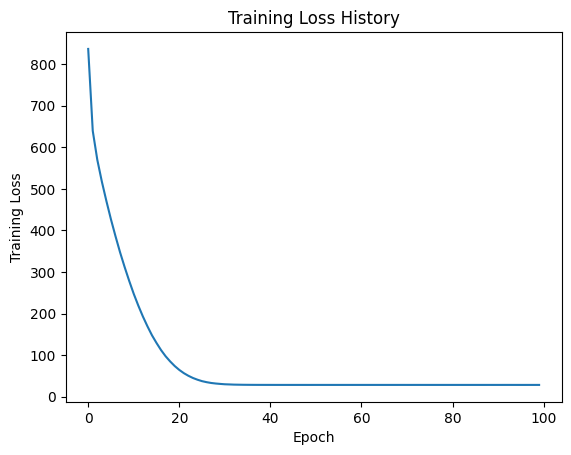

In [90]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(n=15))
model.add(SimpleRNN(64, return_sequences=True))
model.add(GRU(32))
model.add(Dense(8))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_cnn_rnn_gru.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_cnn_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_cnn_rnn_gru")

In [91]:
mavg_hybrid_cnn_rnn_gru_mse

26.969885232286135

### RNN LSTM GRU

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


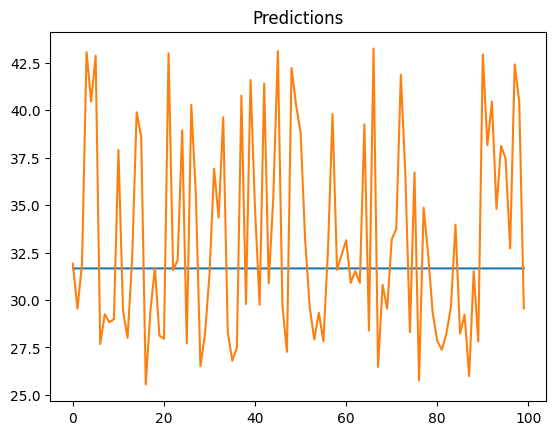

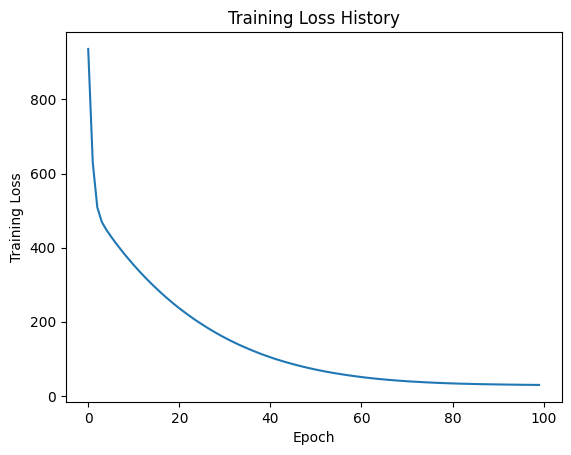

In [92]:
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=input_shape))
model.add(LSTM(128, return_sequences=True))
model.add(GRU(64))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_lstm_rnn_gru.keras"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target,x_val, y_val)

mavg_hybrid_lstm_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_lstm_rnn_gru")

In [93]:
mavg_hybrid_lstm_rnn_gru_mse

28.974239688467918

# MSE

In [94]:
gen = ["General" for _ in range(0,4)]
ma = ["MA" for _ in range(0,4)]
ae = ["AE" for _ in range(0,4)]
ma_ae = ["MA AE" for _ in range(0,4)]
hy = ["HY" for _ in range(0,6)]
ma_hy = ["MA HY" for _ in range(0,6)]

In [95]:
model_cat = []

for a in gen:
    model_cat.append(a)
for a in ma:
    model_cat.append(a)
for a in ae:
    model_cat.append(a)
for a in ma_ae:
    model_cat.append(a)
for a in hy:
    model_cat.append(a)
for a in ma_hy:
    model_cat.append(a)

In [96]:
mse_list = [cnn_mse, rnn_mse, gru_mse, lstm_mse,
            mvg_cnn_mse, mvg_rnn_mse, mvg_gru_mse, mvg_lstm_mse,
            auto_cnn_mse, auto_rnn_mse, auto_gru_mse, auto_lstm_mse,
            mavg_auto_cnn_mse, mavg_auto_rnn_mse, mavg_auto_gru_mse, mavg_auto_lstm_mse,
            hybrid_cnn_lstm_mse, hybrid_lstm_rnn_gru_mse,hybrid_cnn_rnn_gru_mse,hybrid_cnn_gru_mse,
            hybrid_rnn_gru_mse,hybrid_rnn_lstm_mse,
            mavg_hybrid_cnn_lstm_mse, mavg_hybrid_lstm_rnn_gru_mse,mavg_hybrid_cnn_rnn_gru_mse,
            mavg_hybrid_cnn_gru_mse,mavg_hybrid_rnn_gru_mse,mavg_hybrid_rnn_lstm_mse]

model_n = ["CNN", "RNN", "GRU", "LSTM",
           "CNN", "RNN", "GRU", "LSTM",
           "CNN", "RNN", "GRU", "LSTM",
           "CNN", "RNN", "GRU", "LSTM",
           "LSTM", "LSTM RNN GRU" ,"CNN RNN GRU","CNN GRU",
           "RNN GRU","RNN LSTM",
           "CNN LSTM", "LSTM RNN GRU","CNN RNN GRU",
           "CNN GRU","RNN GRU","RNN LSTM"
          ]

msedf = pd.DataFrame({
    "ModelCat": model_cat,
    "Model": model_n,
    "MSE": mse_list
})

rmse = np.sqrt(msedf.MSE)
msedf["RMSE"] = rmse

In [97]:
msedf

,ModelCat,Model,MSE,RMSE
0,General,CNN,2.450006,1.565250
1,General,RNN,58.167284,7.626748
2,General,GRU,934.788134,30.574305
3,General,LSTM,863.977941,29.393502
4,MA,CNN,30.898749,5.558664
5,MA,RNN,30.724507,5.542969
6,MA,GRU,7.535041,2.745003
7,MA,LSTM,11.336891,3.367030
8,AE,CNN,108.847380,10.432995
9,AE,RNN,30.444174,5.517624


In [98]:
msedf.to_csv("msedf.csv", index= False)

<Axes: xlabel='Model'>

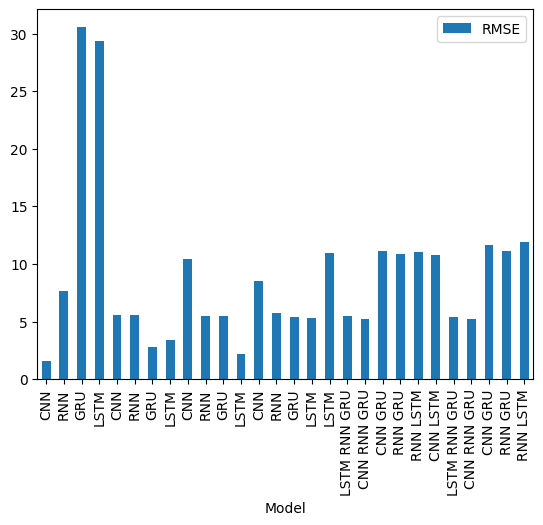

In [99]:
msedf.plot("Model", "RMSE", kind= "bar")

In [100]:
np.save(f"epochs{epochs}/x_train.npy", x_train)
np.save(f"epochs{epochs}/y_train.npy", y_train)
np.save(f"epochs{epochs}/x_test.npy", x_test)
np.save(f"epochs{epochs}/y_test.npy", y_test)
np.save(f"epochs{epochs}/x_val.npy", x_val)
np.save(f"epochs{epochs}/y_val.npy", y_val)